# Nearest Neighbour Based Collaborative Filtering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Reading the dataset

In [3]:
# Dummy data from Videos Dataset

videos_data = pd.read_csv('videos.csv',usecols=['movieId','title'])
videos_data.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [4]:
# Dummy data from Ratings Dataset

rating_data = pd.read_csv('ratings.csv',usecols=['userId', 'movieId', 'rating'])
rating_data.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## Merge the rating and video dataset using common column 'movieId'

In [5]:
data = pd.merge(rating_data,videos_data,on='movieId')
data.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


## Data Cleaning
    - The dummy dataset that we're using for this project is already a clean data but though lets' check if we've any null values.

In [6]:
data.isnull().sum()

userId     0
movieId    0
rating     0
title      0
dtype: int64

# Lets count how much of rating has each video got.

In [7]:
video_ratingCount = (data.groupby(by = ['title'])['rating'].count().reset_index().
                     rename(columns = {'rating': 'totalRatingCount'})[['title', 'totalRatingCount']])
video_ratingCount.head()

,title,totalRatingCount
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


In [8]:
print(len(data), len(video_ratingCount))

100836 9719


### We can see after counting the total rate of each movie, the length of dataset has changed so while merging the whole dataset, we should be aware.

- Lets' use left join to merge the 'data' and 'video_ratingCount'

In [9]:
data_totalRatingCount = data.merge(video_ratingCount, left_on = 'title', right_on = 'title', how = 'left')
data_totalRatingCount.head()

,userId,movieId,rating,title,totalRatingCount
0,1,1,4.0,Toy Story (1995),215
1,5,1,4.0,Toy Story (1995),215
2,7,1,4.5,Toy Story (1995),215
3,15,1,2.5,Toy Story (1995),215
4,17,1,4.5,Toy Story (1995),215


In [10]:
print(video_ratingCount['totalRatingCount'].describe())

count    9719.000000
mean       10.375141
std        22.406220
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: totalRatingCount, dtype: float64


In [11]:
data.columns

Index(['userId', 'movieId', 'rating', 'title'], dtype='object')

# EDA
   Though we've very limited features in current dataset, lets' explore some patterns or relation  among them.

## Count Plot

<AxesSubplot:xlabel='rating', ylabel='count'>

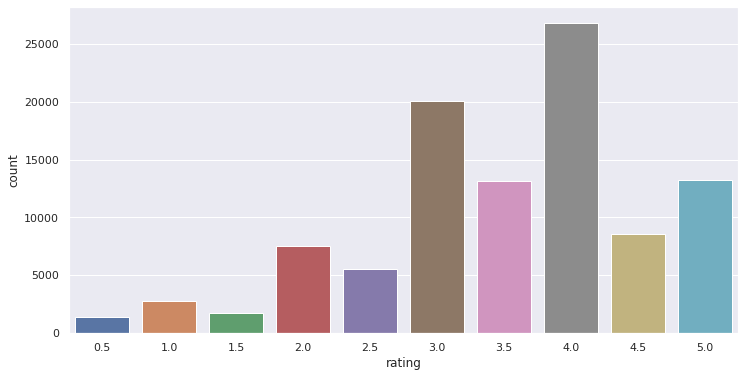

In [12]:
plt.figure(figsize=(12,6))
sns.countplot(x='rating',data=data)

## Summary
1. We can see most of the movies has got Rating '3' and '4'.
2. Low rating are really less.
3. Where as High ratings are quite neutral.

In [13]:
video_ratingCount_slack = video_ratingCount.sort_values(
         by="totalRatingCount",
         ascending=False
     )

popular_video = video_ratingCount_slack.head(5)
flopped_video = video_ratingCount_slack.tail(5)

### Top 5 popular videos

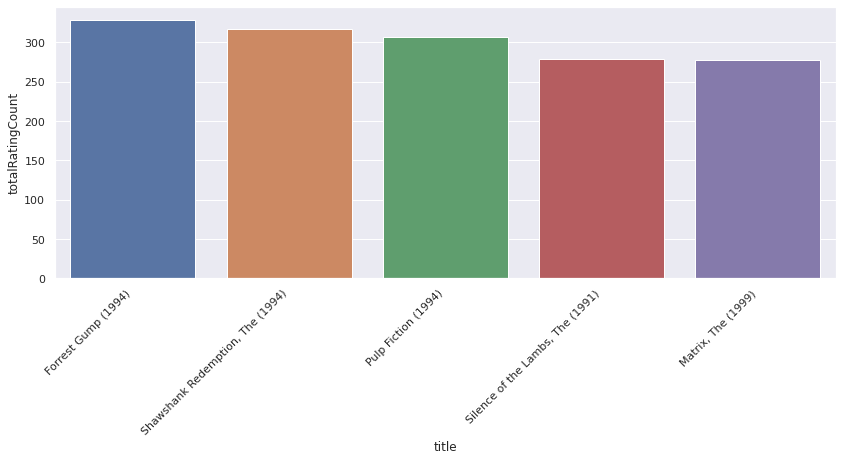

In [14]:
plt.figure(figsize = (14,5))
sns.barplot(x= popular_video['title'],y=popular_video['totalRatingCount'])
plt.xticks(rotation=45, ha="right")
plt.show()

### Top 5 least interacted videos

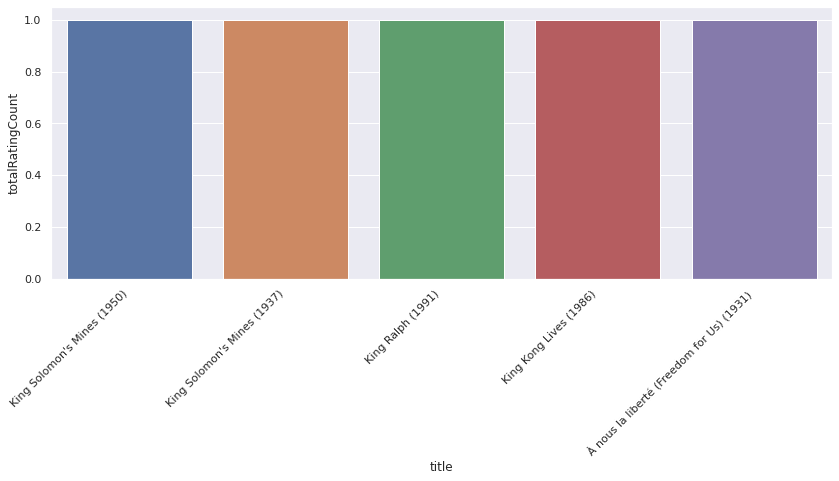

In [15]:
plt.figure(figsize = (14,5))
sns.barplot(x= flopped_video['title'],y=flopped_video['totalRatingCount'])
plt.xticks(rotation=45, ha="right")
plt.show()

## Distribution plot
Let's explore the type of distribution that our data is divided into.

In [16]:
feat = ['rating','totalRatingCount']
list(enumerate(feat))

[(0, 'rating'), (1, 'totalRatingCount')]

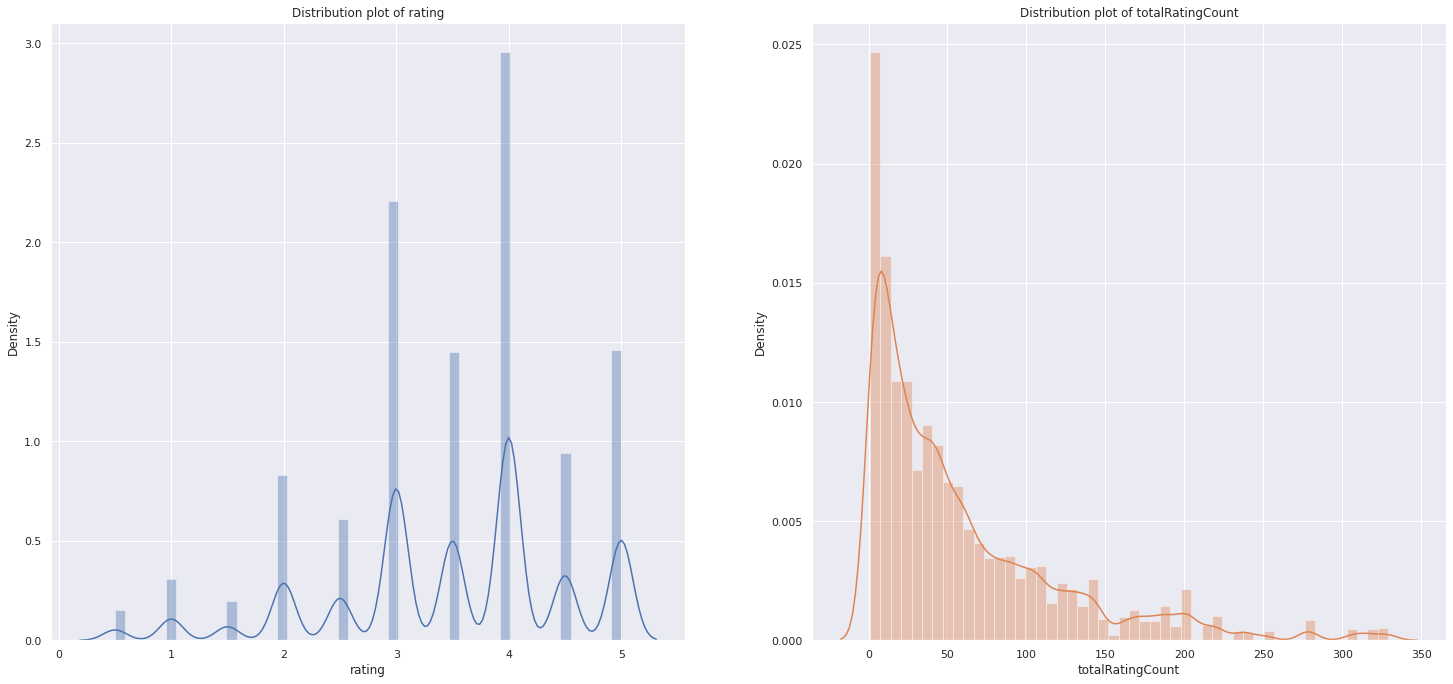

In [17]:
plt.figure(figsize=(25,25))        
for i in enumerate(feat):
    plt.subplot(2,2,i[0]+1)
    base_color = sns.color_palette()[i[0]]
    sns.distplot(data_totalRatingCount[i[1]], color = base_color)
    plt.xlabel(i[1]);
    plt.title(f'Distribution plot of {i[1]}')

## Summary:
    - Its' vwry understanding why we got such plot for rating.
    - Whereas for TotalRatingCount, the distribution is not Gaussion but right skewed. 

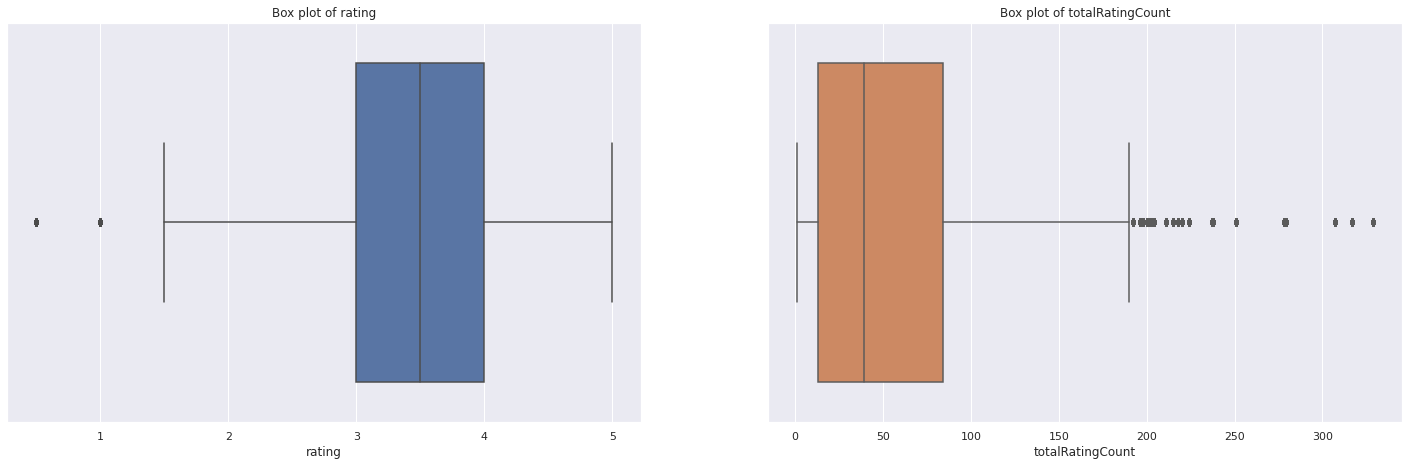

In [18]:
plt.figure(figsize=(25,25))        
for i in enumerate(feat):
    plt.subplot(3,2,i[0]+1)
    base_color = sns.color_palette()[i[0]]
    sns.boxplot(data_totalRatingCount[i[1]] , color = base_color)
    plt.xlabel(i[1]);
    plt.title(f'Box plot of {i[1]}')  

### Summary

    i. Our rating column has quite outliers hmm.
    ii. So lets fix that first.
        - Find the IQR (Interquartile Range)
        - Find the upper and lower limit
        - Find outliers
        - Treat outliers
        - Compare the plots after trimming   
        
  ( But since we have very few  datasets and outliers lets' not go for that.)

### Some movies might be rated by very few persons like 1 or 2. 
    - So, because of this the mean of rating is highly going to be biased, so lets get the rating of only those videos which has received more than certain number.
    - If it will pass specific threshold, then we'll take the video into consideration.

In [19]:
popularity_threshold = 50
rating_popular_video= data_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_video.head()

,userId,movieId,rating,title,totalRatingCount
0,1,1,4.0,Toy Story (1995),215
1,5,1,4.0,Toy Story (1995),215
2,7,1,4.5,Toy Story (1995),215
3,15,1,2.5,Toy Story (1995),215
4,17,1,4.5,Toy Story (1995),215


In [20]:
rating_popular_video.shape

(41362, 5)

### Lets create a Pivot matrix:
    - Index: Title
    - Columns: UserId
    - Values: Ratings

In [21]:
video_features=rating_popular_video.pivot_table(index='title',columns='userId',values='rating').fillna(0)
video_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
12 Angry Men (1957),0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001: A Space Odyssey (1968),0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,5.0,0.0,3.0,0.0,4.5
28 Days Later (2002),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,5.0
300 (2007),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,4.0


# 

In [22]:
from scipy.sparse import csr_matrix

video_features_matrix = csr_matrix(video_features.values)
video_features_matrix

<450x606 sparse matrix of type '<class 'numpy.float64'>'
	with 41360 stored elements in Compressed Sparse Row format>

### Calculate the cosine similarity using Nearest Neighbour

In [23]:
from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(video_features_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [24]:
video_features.shape

(450, 606)

### Randomly considering User X watched one Random video Y

In [25]:
query_index = np.random.choice(video_features.shape[0])
print(query_index)

414


In [26]:
distances, indices = model_knn.kneighbors(video_features.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

In [27]:
video_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
12 Angry Men (1957),0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001: A Space Odyssey (1968),0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,5.0,0.0,3.0,0.0,4.5
28 Days Later (2002),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,5.0
300 (2007),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,4.0


### Get the recommended videos

In [28]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(video_features.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, video_features.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Tron (1982):

1: RoboCop (1987), with distance of 0.4333110059193197:
2: Total Recall (1990), with distance of 0.5267681600937928:
3: Star Wars: Episode I - The Phantom Menace (1999), with distance of 0.5270073286035528:
4: Predator (1987), with distance of 0.5352344047252271:
5: Blade (1998), with distance of 0.5359050654742769:
